In [48]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [43]:
def detectObject(img_path, detector:cv2.CascadeClassifier):
    """Returns (x,y,w,h) bounding boxes for the objects detected."""
    # TODO might have to convert to grayscale first
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_eq = cv2.equalizeHist(img)
    
    # Detect the objects
    objs = detector.detectMultiScale(img_eq)
    return objs    

In [56]:
def displayImage(imgpath, bboxes, axe=None):
    """
    Uses matplotlib to display an image with bounding boxes
    """
    img = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
    for (x,y,w,h) in bboxes:
        img = cv2.rectangle(img, (x, y), (x+w, y+h), 255)
    if axe:
        axe.imshow(img, cmap='Greys')
    else:
        plt.imshow(img, cmap='Greys')

In [27]:
od_model_path = "/home/tensorflow/waste/datasets/taco_dataset/cascade_od/cascade.xml"

Load the cascade classifier

In [28]:
od_model = cv2.CascadeClassifier()

In [29]:
if not od_model.load(cv2.samples.findFile(od_model_path)):
    print("Error loading the cascade OD model")

In [47]:
dataset = "/home/tensorflow/waste/datasets/taco_dataset/test/small"

In [52]:
img_path = os.path.join(dataset,"qsVObW14EAkHdteGVorNIWcgUJT13lhYnYYLBZVC.jpeg")

In [53]:
bboxes = detectObject(img_path, od_model)

In [54]:
len(bboxes)

31

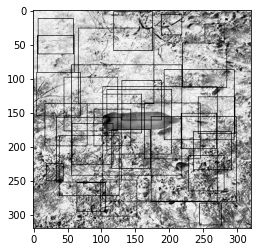

In [57]:
displayImage(img_path, bboxes)

Evaluate detection rate

In [59]:
import time

In [61]:
start = time.perf_counter()
num_imgs = 0
for img_path in os.listdir(dataset):
    detectObject(os.path.join(dataset, img_path), od_model)
    num_imgs += 1
end = time.perf_counter()
print(f"Avg detection time {(end-start)/num_imgs}")

Avg detection time 0.03966060774999076


The detection is not working well and it takes too long.

### Simple image classification

The simple classifier will have two classes: waste or not waste.

We will use the trashnet dataset. It will be split into training and test.

1. Extract SIFT descriptors from image
2. Cluster the descriptors into K clusters
3. Convert the descriptors for each image into a histogram, where each bin represents a cluster.

For each image
* extract the SIFT descriptors
* assign the descriptors to the identified clusters
* convert into a histogram, where each bin represents a cluster

This is based on Ian London's General Image Classifier: 

https://github.com/IanLondon/general_img_classifier

Load the images into two groups, trash and non-trash.

In [98]:
import random

In [90]:
dataset = '/home/tensorflow/waste/datasets/trashnet-resized/'

In [92]:
non_trash_images = []
for folder in os.listdir(dataset):
    if folder != 'trash':
        for img_name in os.listdir(os.path.join(dataset, folder)):
            non_trash_images.append(os.path.join(dataset, folder, img_name))
            

In [95]:
trash_images = []
for img_name in os.listdir(os.path.join(dataset, 'trash')):
    trash_images.append(os.path.join(dataset, 'trash', img_name))

Balance the classes

In [99]:
non_trash_images = random.sample(non_trash_images, len(trash_images))

In [102]:
data = {'trash': trash_images, 'nontrash': non_trash_images}

Split into training and test, 80-20

In [103]:
num_train = int(0.8*len(trash_images))

In [104]:
num_test = int(0.2*len(trash_images))

In [105]:
train_data = {'trash': trash_images[:num_train],
              'nontrash': non_trash_images[:num_train]}
test_data = {'trash': trash_images[num_train:],
              'nontrash': non_trash_images[num_train:]}

Generate SIFT features

In [107]:
def gen_sift_features(images):
    """Generates SIFT features for the list of image paths"""
    sift_features = []
    sift = cv2.SIFT_create()
    for img_path in images:
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, desc = sift.detectAndCompute(gray, None)
        sift_features.append(desc)
    return sift_features        

Cluster SIFT features

In [121]:
def find_sift_clusters(sift_features, cluster_model):
    """Converts the SIFT feature for every image into a bag of words"""
    n_clusters = cluster_model.n_clusters
    # Flatten the sift_features
    train_descriptors = np.array([desc for desc_list in sift_features
                                       for desc in desc_list])
    # Train the clustering model on the descriptors
    cluster_model.fit(train_descriptors)
    return cluster_model

def generate_bag_of_words(sift_features, cluster_model):
    """Generates bag of words for all images captured in sift_features"""
    n_clusters = cluster_model.n_clusters
    # Find clusters for each image
    img_clustered_words = [cluster_model.predict(desc) for desc in sift_features]
    
    # Convert to histograms (bag of words)
    img_bow_hist = np.array([np.bincount(clustered_words, minlength=n_clusters)
                            for clustered_words in img_clustered_words])
    return img_bow_hist, cluster_model

In [114]:
sift_features_train = {k:gen_sift_features(v) for k,v in train_data.items()}

In [115]:
sift_features_train_all = sift_features_train['trash'] + sift_features_train['nontrash']

In [122]:
sift_features_test = {k:gen_sift_features(v) for k,v in test_data.items()}

In [123]:
sift_features_test_all = sift_features_test['trash'] + sift_features_test['nontrash']

In [117]:
from sklearn.cluster import MiniBatchKMeans

In [124]:
cluster_model = find_sift_clusters(sift_features_train_all,
                                  MiniBatchKMeans(50))

In [125]:
bow_hist, cluster_model = generate_bag_of_words(
                sift_features_train_all+sift_features_test_all,
                                               cluster_model)

In [126]:
bow_hist.shape

(274, 50)

In [128]:
def split_bow(bow_hist, train_dict, test_dict):
    """Split the BoW data into train and test"""
    x_train = bow_hist[:len(train_dict['trash'])+len(train_dict['nontrash'])]
    y_train = [1]*len(train_dict['trash'])+[0]*len(train_dict['nontrash'])
    x_test = bow_hist[len(train_dict['trash'])+len(train_dict['nontrash']):]
    y_test = [1]*len(test_dict['trash'])+[0]*len(test_dict['nontrash'])
    return x_train, y_train, x_test, y_test

In [130]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [138]:
def run_svm(X_train, X_test, y_train, y_test, scoring,
    c_vals=[1, 5, 10], gamma_vals=[0.1, 0.01, 0.0001, 0.00001]):

    param_grid = [
    #   {'C': c_vals, 'kernel': ['linear']},
      {'C': c_vals, 'gamma': gamma_vals, 'kernel': ['rbf']},
     ]

    svc = GridSearchCV(SVC(), param_grid, n_jobs=-1, scoring=scoring)
    svc.fit(X_train, y_train)
    train_score = svc.score(X_train, y_train)
    print(f"train score {scoring}: {train_score}")
    test_score = svc.score(X_test, y_test)
    print(f"test score {scoring}: {test_score}")

    print(svc.best_estimator_)

    return svc, test_score

In [132]:
X_train, y_train, X_test, y_test = split_bow(bow_hist, train_data, test_data)

In [139]:
svc, test_score = run_svm(X_train, X_test, y_train, y_test, "recall_micro")

train score recall_micro: 0.8394495412844036
test score recall_micro: 0.7678571428571429
SVC(C=5, gamma=0.0001)


In [140]:
def img_to_vect(img_path, cluster_model):
    """
    Given an image path and a trained clustering model (eg KMeans),
    generates a feature vector representing that image.
    Useful for processing new images for a classifier prediction.
    """
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp, desc = sift.detectAndCompute(gray, None)

    clustered_desc = cluster_model.predict(desc)
    img_bow_hist = np.bincount(clustered_desc, minlength=cluster_model.n_clusters)

    # reshape to an array containing 1 array: array[[1,2,3]]
    # to make sklearn happy (it doesn't like 1d arrays as data!)
    return img_bow_hist.reshape(1,-1)

In [145]:
start_time = time.perf_counter()
trash_cat = 0
nontrash_cat = 0
for img_path in test_data['trash']:
    cat = svc.predict(img_to_vect(img_path, cluster_model))
    trash_cat += cat
for img_path in test_data['nontrash']:
    cat = svc.predict(img_to_vect(img_path, cluster_model))
    nontrash_cat += cat
end_time = time.perf_counter()
proc_time = (end_time-start_time)/(len(test_data['trash'])+len(test_data['nontrash']))
trash_acc = trash_cat/len(test_data['trash'])
nontrash_acc = 1-nontrash_cat/len(test_data['nontrash'])
print(f"Proc time {proc_time}. Trash acc {trash_acc}. Nontrash acc {nontrash_acc}")


Proc time 0.05967005958934481. Trash acc [0.71428571]. Nontrash acc [0.82142857]


### Non-trash classification

In [147]:
non_trash_images = {}
for folder in os.listdir(dataset):
    if folder == 'trash': continue
    non_trash_images[folder] = []
    for img_name in os.listdir(os.path.join(dataset, folder)):
        non_trash_images[folder].append(
                    os.path.join(dataset, folder, img_name))

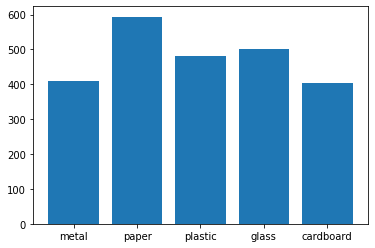

In [151]:
plt.bar(range(len(non_trash_images)), [len(cat) for cat in non_trash_images.values()])
_=plt.xticks(range(len(non_trash_images)), non_trash_images.keys())